<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bootstrapping and Bagging

### Learning Objectives
- Define ensemble model.

`Ensemble method is to create multiple models and combine it by aggregating it`


- Name three advantages of using ensemble models.


`Can aggregate with many decision trees assuming all are randomly split by bagging.`



- Define and execute bootstrapping.


`Bootstrapping is the idea of taking random samples with replacement`

`We bootstrap when fitting bagged decision trees so that we can fit multiple decision trees on slightly different sets of data. Bagged decision trees tend to outperform single decision trees.`

`Bootstrapping can also be used to conduct hypothesis tests and generate confidence intervals directly from resampled data.`


- Fit and evaluate bagged decision trees.

In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Import Bagging Classifier.
from sklearn.ensemble import BaggingClassifier

## Load the Data

We'll be using the `Heart.csv` from the [ISLR Website](https://www.statlearning.com/). There's a copy in this repo under `./datasets/Heart.csv`.

In [2]:
# Read in the Heart .csv data.
df = pd.read_csv('../datasets/Heart.csv')

# Check the first few rows.
df.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


## Data Cleaning & Model Prep

In [3]:
# Drop the `Unnamed: 0` column.
df.drop('Unnamed: 0', axis=1, inplace=True)

# Drop NAs.
df.dropna(inplace=True)

# Create dummies for the `ChestPain`, `Thal`, and `AHD` columns.
# Be sure to set `drop_first=True`.
df = pd.get_dummies(df,
                    columns=['ChestPain', 'Thal', 'AHD'],
                    drop_first=True)

# Define X and y.
X = df.drop('AHD_Yes', axis='columns')
y = df['AHD_Yes']

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

Our target column will be `AHD_Yes`: 
- 1 means the patient has heart disease
- 0 means they aren't diagnosed with heart disease

In [4]:
# What is the accuracy of our baseline model?
y.value_counts(normalize=True)

0    0.538721
1    0.461279
Name: AHD_Yes, dtype: float64

<details><summary>What does a false positive mean in this case?</summary>
    
- A false positive indicates someone **falsely** predict as being in the **positive** class.
- This is someone we incorrectly think has heart disease.
- Incorrectly predicting someone to have heart disease is bad... but it _might_ be worse to incorrectly predict that someone is healthy!
</details>

In [5]:
# Instantiate `DecisionTreeClassifier` object.
tree = DecisionTreeClassifier(random_state=42)

## Note: The role of randomness

The algorithms that fit tree-based methods involve randomness, which means it's important to specify a `random_state` if you want to reproduce your results. This is always a good idea.
- Changing `random_state` from 42 to 43 reduces our model's test performance by 6%!

In [6]:
# Fit and score on the training data.
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

1.0

In [7]:
# Score on the testing data.
tree.score(X_test, y_test)

0.72

<details><summary> Where do decision trees tend to fall on the Bias/Variance spectrum?</summary>
    
- Decision trees very easily overfit.
- They tend to suffer from **high error due to variance**.
</details>

## Bootstrapping

Bootstrapping is a powerful idea used frequently across statistics and data science.
- One common use for bootstrapping is to use computers and random number generation to generate confidence intervals or execute hypothesis tests for us, instead of relying on the Central Limit Theorem and memorized formulas.
- We'll use it later to improve the performance of our decision tree models!


#### What is the motivation behind bootstrapping?
In a perfect world, we would have access to the full population of data instead of a sample of data.

<details><summary>Why is it unrealistic to assume we have access to the full population of data?</summary>
    
- It would take too much time.
- It would cost too much money.
- Logistical challenges.
</details>

In a few words, bootstrapping is **random resampling with replacement**.

The idea is this:
- Take your original sample of data, with sample size $n$.
- Take many sub-samples (say $B$) of size $n$ from your sample **with replacement**. These are called **bootstrapped samples**.
- You have now generated $B$ bootstrapped samples, where each sample is of size $n$!

<img src="../assets/bootstrap.png" alt="drawing" width="550"/>

- Instead of building one model on our original sample, we will now build one model on each bootstrapped sample, giving us $B$ models in total!
- Experience tells us that combining the models from our bootstrapped samples will be closer to what we'd see from the population than to just get one model from our original sample.

This sets up the idea of an **ensemble model**.

<details><summary>Why do you think we want to take a sample of size n?</summary>
    
- Because we want our estimators to be fit on data of the same size!
- If our original data had a sample size of 1,000, but we fit decision trees to samples of size 50, the decision trees fit to samples of size 50 will probably look very, very different from decision trees fit on a sample of size 1,000.
</details>

<details><summary>Why do you think we want to sample with replacement?</summary>
    
- If we didn't sample with replacement, we'd just get identical samples of size $n$. (These would be copies of our original data!)
</details>

If you are generating one bootstrapped sample in `pandas`:

In [8]:
# Generate one bootstrapped sample
# of size n from X_train.
# same size but with replacement 

X_train.sample(n = X_train.shape[0],
               replace = True,
            #    random_state = 42
               )

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
209,62,0,150,244,0,0,154,1,1.4,2,0.0,0,0,0,1,0
140,59,1,140,221,0,0,164,1,0.0,1,0.0,0,1,0,1,0
283,35,1,122,192,0,0,174,0,0.0,1,0.0,0,1,0,1,0
30,69,0,140,239,0,0,151,0,1.8,1,2.0,0,0,1,1,0
263,44,1,120,226,0,0,169,0,0.0,1,0.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,43,0,122,213,0,0,165,0,0.2,2,0.0,1,0,0,1,0
211,38,1,120,231,0,0,182,1,3.8,2,0.0,0,0,1,0,1
139,51,1,125,245,1,2,166,0,2.4,2,0.0,1,0,0,1,0
276,66,0,146,278,0,2,152,0,0.0,2,1.0,1,0,0,1,0


Let's visualize some bootstrapped samples.

c:\Users\Admin\.conda\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Admin\.conda\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Admin\.conda\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

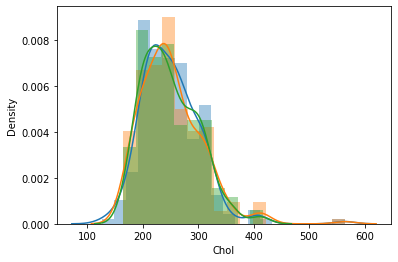

In [9]:
# Create bootstrapped samples 
# & plot cholesterol level for each bootstrapped sample.
for i in range(3):
    sns.distplot(X_train.sample(n = X_train.shape[0], replace = True)['Chol']);

## Introduction to Ensemble Methods
We can list out the different types of models we've built thus far:
- Linear Regression
- Logistic Regression
- $k$-Nearest Neighbors
- Naive Bayes Classification

If we want to use any of these models, we follow the same type of process.
1. Based on our problem, we identify which model to use. (Is our problem classification or regression? Do we want an interpretable model?)
2. Fit the model using the training data.
3. Use the fit model to generate predictions.
4. Evaluate our model's performance and, if necessary, return to step 2 and make changes.

So far, we've always had exactly one model. Today, however, we're going to talk about **ensemble methods**. Mentally, you should think about this as if we build multiple models and then aggregate their results in some way.

## Why would we build an "ensemble model?"

Our goal is to estimate $f$, the true function. (Think about $f$ as the **true process** that dictates Ames housing prices.)

We can come up with different models $m_1$, $m_2$, and so on to get as close to $f$ as possible. (Think about $m_1$ as the model you built to predict $f$, think of $m_2$ as the model your neighbor built to predict $f$, and so on.)

### (BONUS) Three Benefits: Statistical, Computational, Representational
- The **statistical** benefit to ensemble methods: By building one model, our predictions are almost certainly going to be wrong. Predictions from one model might overestimate housing prices; predictions from another model might underestimate housing prices. By "averaging" predictions from multiple models, we'll see that we can often cancel our errors out and get closer to the true function $f$.
- The **computational** benefit to ensemble methods: It might be impossible to develop one model that globally optimizes our objective function. (Remember that CART reach locally-optimal solutions that aren't guaranteed to be the globally-optimal solution.) In these cases, it may be **impossible** for one CART to arrive at the true function $f$. However, generating many different models and averaging their predictions may allow us to get results that are closer to the global optimum than any individual model.
- The **representational** benefit to ensemble methods: Even if we had all the data and all the computer power in the world, it might be impossible for one model to **exactly** equal $f$. For example, a linear regression model can never model a relationship where a one-unit change in $X$ is associated with some *different* change in $Y$ based on the value of $X$. All models have some shortcomings. (See [the no free lunch theorems](https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization).) While individual models have shortcomings, by creating multiple models and aggregating their predictions, we can actually create predictions that represent something that one model cannot ever represent.

We can summarize this as the **wisdom of the crowd**.

## Wisdom of the Crowd: Guess the weight of Penelope

![](../assets/penelope.jpg)

[*Image source*](https://www.npr.org/sections/money/2015/07/17/422881071/how-much-does-this-cow-weigh)

## Ensemble models

We can use the "wisdom of the crowd" idea by creating several models and then aggregating their results in some way.

Types of ensemble models:
- Bagging
- Boosting
- [Stacking](https://www.geeksforgeeks.org/stacking-in-machine-learning/)

## Bagging: Bootstrap Aggregating

Decision trees are powerful machine learning models. However, decision trees have some limitations. In particular, trees that are grown very deep tend to learn highly irregular patterns (a.k.a. they overfit their training sets). 

Bagging (bootstrap aggregating) mitigates this problem by exposing different trees to different sub-samples of the training set.

The process for creating bagged decision trees is as follows:
1. From the original data of size $n$, bootstrap $B$ samples each of size $n$ (with replacement!).
2. Build a decision tree on each bootstrapped sample.
3. Make predictions by passing a test observation through all $B$ trees and developing one aggregate prediction for that observation.

![](../assets/Ensemble.png)

### What do you mean by "aggregate prediction?"
As with all of our modeling techniques, we want to make sure that we can come up with one final prediction for each observation.

Suppose we want to predict whether or not a Reddit post is going to go viral, where `1` indicates viral and `0` indicates non-viral. We build 100 decision trees. Given a new Reddit post labeled `X_test`, we pass these features into all 100 decision trees.
- 70 of the trees predict that the post in `X_test` will go viral.
- 30 of the trees predict that the post in `X_test` will not go viral.

<details><summary>What might you expect .predict(X_test) to output?</summary>

- `.predict(X_test)` should output a 1, predicting that the post will go viral.

</details>

<details><summary>What might you expect .predict_proba(X_test) to output?</summary>

- `.predict_proba(X_test)` should output [0.3 0.7], indicating the probability of the post going viral is 70% and the probability of the post not going viral to be 30%.
</details>


## Bagging Classifier using a `for` loop

In the cell below, we'll create an ensemble of trees - we'll train each tree on a separate **bootstrapped** sample of the training data.

In [10]:
# Instantiate dataframe.
predictions = pd.DataFrame(index=X_test.index)

# Generate ten decision trees.
for i in range(1, 11):
    
    # Bootstrap X data.
    # Should we add a random seed?
    X_sample = X_train.sample(n = X_train.shape[0],
                              replace=True)
    
    # Get y data that matches the X data.
    y_sample = y_train[X_sample.index]
    
    # Instantiate decision tree.
    t = DecisionTreeClassifier()
    
    # Fit to our sample data.
    t.fit(X_sample, y_sample)
    
    # Put predictions in dataframe.
    predictions[f'Tree {i}'] = t.predict(X_test)

predictions.head()

,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10
113,1,1,1,1,1,1,1,1,1,1
195,1,1,0,1,1,1,1,0,1,1
64,1,1,1,1,1,1,1,1,1,1
27,0,0,0,1,0,1,0,1,0,0
245,1,0,0,1,0,1,0,1,1,0


In [11]:
# Generate aggregated predicted probabilities.
predictions.mean(axis='columns')

113    1.0
195    0.8
64     1.0
27     0.3
245    0.5
      ... 
93     0.4
133    0.0
33     0.5
20     0.5
76     1.0
Length: 75, dtype: float64

In [12]:
# Generate aggregated predicted probabilities as probs.
probs = predictions.mean(axis='columns')

In [13]:
accuracy_score(y_test, (probs > .5).astype(int))

0.8266666666666667

## Bagging Classifier using `sklearn`

[BaggingClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In the cell below, create and score instance of `BaggingClassifier` on the test set. 

In [14]:
# Instantiate BaggingClassifier.
bag = BaggingClassifier(
    random_state = 42,
    base_estimator= DecisionTreeClassifier(),
    n_estimators = 1000, # number of base estimators we use 
    )

# Fit BaggingClassifier.
bag.fit(X_train, y_train)

# Score BaggingClassifier.
bag.score(X_test, y_test)

0.8

## Interview Question

<details><summary>What is bootstrapping?</summary>

- Bootstrapping is random resampling with replacement.
- We bootstrap when fitting bagged decision trees so that we can fit multiple decision trees on slightly different sets of data. Bagged decision trees tend to outperform single decision trees.
- Bootstrapping can also be used to conduct hypothesis tests and generate confidence intervals directly from resampled data.
</details>